In [1]:
%load_ext autoreload
%autoreload 2

#expr_path = '/home/sbanerjee/Documents/work/sparse-regression/gradvi-experiments/dsc/functions'
expr_path = '/home/saikat/Documents/work/sparse-regression/mr-ash-penalized/gradvi-experiments/dsc/functions'

import numpy as np
import sys
sys.path.append(expr_path)
import simulate

import matplotlib
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import patsy
from gradvi.models import basis_matrix as basemat
import collections

CData = collections.namedtuple('CData', ['x', 'y', 'ytest', 'ytrue', 'btrue', 'bspline_bases', 'bsp_beta'])

def changepoint_from_bspline (x, knots, std,
                 degree = 0, signal = "gamma", seed = None,
                 include_intercept = False, bfix = None,
                 eps = 1e-8, get_bsplines = False):
    if seed is not None: np.random.seed(seed)
    # ------------------------------
    n = x.shape[0]
    # ------------------------------
    # Generate B-spline bases given the knots and degree
    bspline_bases = patsy.bs(x, knots = knots, degree = degree, include_intercept = include_intercept)
    nbases = knots.shape[0] + degree + int(include_intercept)
    assert bspline_bases.shape[1] == nbases, "Number of B-spline bases does not match the number of knots + degree + interecept"
    # ------------------------------
    # Generate coefficients for the bases
    beta   = simulate.sample_coefs(nbases, np.arange(nbases), method = signal, bfix = bfix)
    # ------------------------------
    # Generate the function without noise 
    ytrue = np.dot(bspline_bases, beta)
    # ------------------------------
    # Map the data to trendfiltering bases
    # set low values of beta to zero and regenerate y
    H     = basemat.trendfiltering_scaled(n, degree)
    Hinv  = basemat.trendfiltering_inverse_scaled(n, degree)
    btrue = np.dot(Hinv, ytrue)
    btrue[np.abs(btrue) <= eps] = 0.
    noise = np.random.normal(0, std, size = n * 2)
    ytrue = np.dot(H, btrue)
    y     = ytrue + noise[:n]
    # ------------------------------
    # Some test data?
    ytest = ytrue + noise[n:]
    # ------------------------------
    data  = CData(x = x, y = y, ytest = ytest, ytrue = ytrue, btrue = btrue,
                  bspline_bases = bspline_bases, bsp_beta = beta)
    # ------------------------------
    # Signal to noise ratio 
    # (experimental)
    #signal = np.mean(np.square(btrue[btrue != 0]))
    #snr    = signal / np.square(std)
    #data   = CData(x = x, y = y, ytest = ytest, ytrue = ytrue, btrue = btrue)
    #if get_bsplines:
    #    data = CData(x = x, y = y, ytest = ytest, ytrue = ytrue, btrue = btrue, 
    #        bspline_bases = bspline_bases, bsp_beta = beta)
    return data
    #return y, ytest, ytrue, btrue

In [3]:
n = 512
x = np.linspace(0, 1, n)
np.random.seed(100)

degrees = [0, 1, 2]
nknots  = 4
strue = 0.1
knots = np.linspace(0, 1, nknots+2)[1:-1]

data = dict()

for degree in degrees:
    bfix = np.random.normal(0, 1, size = nknots + degree)
    data[degree] = changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "fixed", bfix = bfix, seed = 100, 
                        include_intercept = False)

In [4]:
nknots

4

In [5]:
knots

array([0.2, 0.4, 0.6, 0.8])

In [6]:
degree

2

In [8]:
nbases = knots.shape[0] + degree
bfix = simulate.sample_coefs(nbases, np.arange(nbases), method = "normal", bfix = None)
bfix

array([ 0.03104795, -1.73909927,  0.08649406, -0.49104597, -2.67435495,
        0.64435936])

In [10]:
simulate.sample_coefs(nbases, np.arange(nbases), method = "fixed", bfix = bfix)

array([ 0.03104795, -1.73909927,  0.08649406, -0.49104597, -2.67435495,
        0.64435936])

In [11]:
from mrashpen.utils import R_trendfilter

tf_y, tf_fit = R_trendfilter.fit(data[degree].y, order = degree)
Hinv = basemat.trendfiltering_inverse_scaled(n, degree)
tf_bhat  = np.dot(Hinv, tf_y)

R[write to console]: Loading required package: Matrix



Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [21]:
tf_fit['df']

8.0

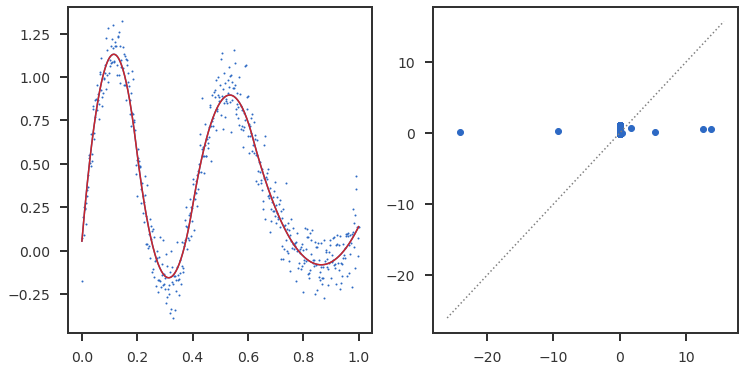

In [24]:
H     = basemat.trendfiltering_scaled(n, degree)

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(data[degree].x, data[degree].y, s = 1)
ax1.plot(data[degree].x, tf_fit['ypred'])
ax1.plot(data[degree].x, np.dot(H, tf_bhat))
ax2.scatter(tf_bhat, tf_fit['beta'])
mpl_utils.plot_diag(ax2)
plt.show()

In [25]:
from gradvi.tests import toy_priors

prior_init = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (degree + 1) * 20)
prior_init.sk

array([ 0.        ,  0.50596585,  1.26793316,  2.41542989,  4.1435208 ,
        6.74596669, 10.66516135, 16.56733468, 25.45580619, 38.84154077])

In [50]:
toy_priors.get_ash_scaled(k = 20, sparsity = 0.9, skbase = (degree + 1) * 20).sk

array([ 0.        ,  0.227178  ,  0.50596585,  0.84808817,  1.26793316,
        1.78315768,  2.41542989,  3.19134044,  4.1435208 ,  5.31201559,
        6.74596669,  8.50567995, 10.66516135, 13.31522943, 16.56733468,
       20.55824672, 25.45580619, 31.46598344, 38.84154077, 47.8926625 ])

In [48]:
np.round(data[2].btrue[data[2].btrue != 0], 1)

array([  0.4,   5.7, -25.3,   8.9,  18.3,   0.6,  -1.9,  -7.6,  -0.8,
         0.2,   1.5,   0.4,  -0. ,  -0. ,  -0. ])

In [49]:
np.power(((degree + 1) * 20), (np.arange(20) / 20)) - 1

array([ 0.        ,  0.227178  ,  0.50596585,  0.84808817,  1.26793316,
        1.78315768,  2.41542989,  3.19134044,  4.1435208 ,  5.31201559,
        6.74596669,  8.50567995, 10.66516135, 13.31522943, 16.56733468,
       20.55824672, 25.45580619, 31.46598344, 38.84154077, 47.8926625 ])

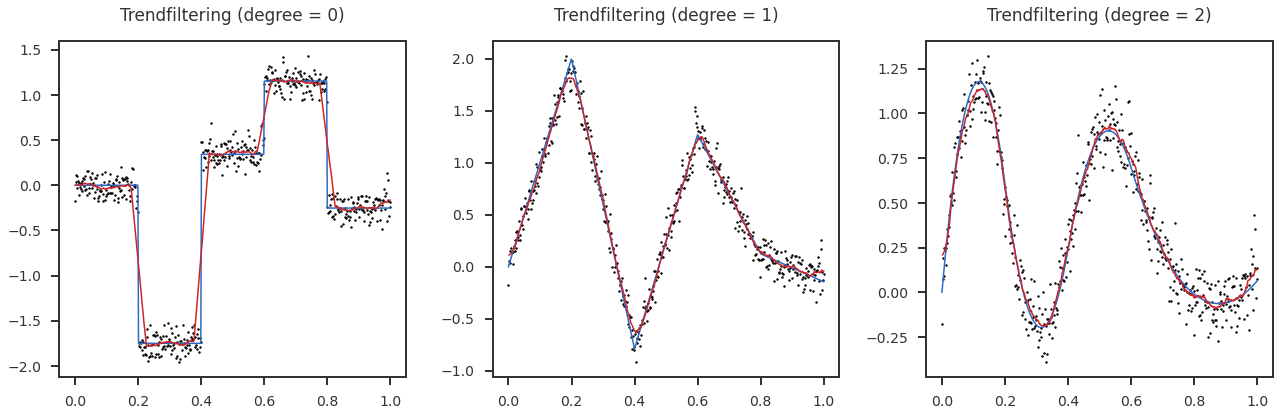

In [51]:
from gradvi.optimize import moving_average

fig = plt.figure(figsize = (18, 6))
for i, d in enumerate(degrees):
    yma = moving_average.moving_average(data[d].y, method = 'cumsum')
    
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(data[d].x, data[d].y, s = 2, color = 'black')
    ax.plot(data[d].x, data[d].ytrue)
    ax.plot(data[d].x[1:], yma)
    ax.set_title(f"Trendfiltering (degree = {d})", pad = 20)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
plt.show()

In [55]:
from gradvi.tests import toy_priors
from gradvi.optimize import moving_average
from gradvi.inference import LinearRegression

CRes = collections.namedtuple('CRes', ['y', 'coef', 's2', 'prior'])

def gradvi_trendfilter(y, degree, b0 = None, s0 = None):
    n = y.shape[0]
    H = basemat.trendfiltering_scaled(n, degree)
    #Hinv = basemat.trendfiltering_inverse_scaled(n, degree)
    
    prior_init = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (degree + 1) * 20)
    
    # Initialize
    if b0 is None:
        y0     = y.copy()
        y0[1:] = moving_average.moving_average(y)
        b0     = np.zeros_like(y0)
    
    if s0 is None:
        s0 = np.var(y - y0) / 10.
        
    gv0 = LinearRegression(optimize_s = False, maxiter = 1000, obj = 'direct', tol = 1e-7)
    gv0.fit(H, y, prior_init, b_init = b0, s2_init = s0)
    
    # Run 
    prior = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (degree + 1) * 20) 
    gv1 = LinearRegression(maxiter = 10000, obj = 'reparametrize', tol = 1e-8)
    gv1.fit(H, y, prior, t_init = gv0.theta, s2_init = gv0.residual_var)
    
    # Result
    coef = gv1.coef
    yest = np.dot(H, coef) + gv1.intercept
    return CRes(y = yest, coef = coef, s2 = gv1.residual_var, prior = gv1.prior)

In [56]:
res = dict()
for degree in degrees:
    res[degree] = gradvi_trendfilter(data[degree].y, degree)

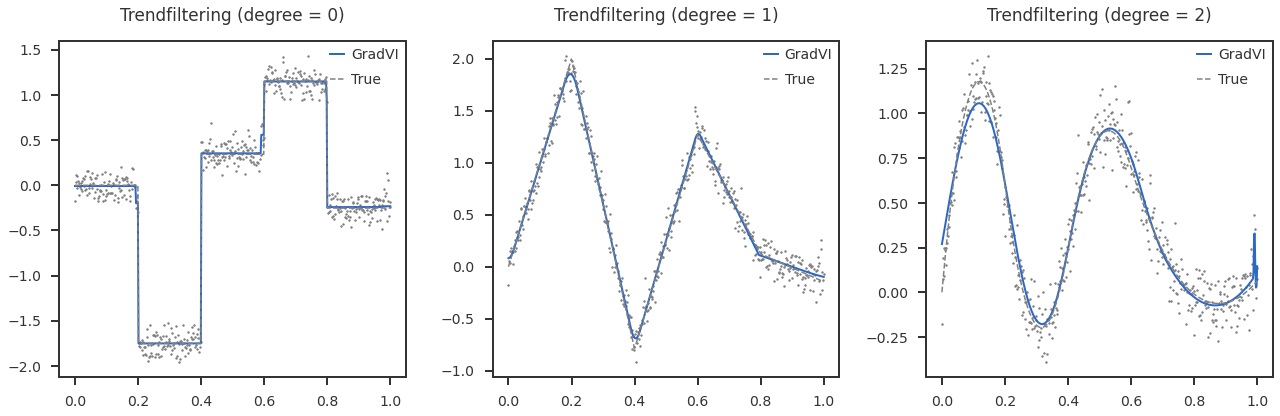

In [57]:
fig = plt.figure(figsize = (18, 6))
for i, d in enumerate(degrees):
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(data[d].x, data[d].y, s = 2, color = 'grey')

    ax.plot(data[d].x, res[d].y, lw = 2, label = 'GradVI')
    ax.plot(data[d].x, data[d].ytrue, label = 'True', color = 'grey', ls = 'dashed')
    ax.set_title(f"Trendfiltering (degree = {d})", pad = 20)
    ax.legend()
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
plt.show()

In [37]:
for i, d in enumerate(degrees):
    s0 = np.var(data[d].y - data[d].ytrue)
    print(res[d].s2, s0)

0.04803325116219869 0.011157945646860637
0.011102165485268881 0.011157945646860637
0.010641362967763069 0.011157945646860637


In [122]:
degree = 2
H = basemat.trendfiltering_scaled(n, degree)
Hinv = basemat.trendfiltering_inverse_scaled(n, degree)

y0     = data[degree].y.copy()
y0[1:] = moving_average.moving_average(data[degree].y)
#b0 = np.dot(Hinv, y0)
b0 = np.zeros_like(y0)
s0 = np.var(data[degree].y - y0) / 10

prior_init = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (degree + 1) * 20)
gv0 = LinearRegression(optimize_s = False, maxiter = 1000, obj = 'direct', tol = 1e-7)
gv0.fit(H, data[degree].y, prior_init, b_init = np.zeros_like(b0), s2_init = s0)
print(gv0.residual_var)
print(gv0.fitobj.message)

prior = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (degree + 1) * 20)
gv1 = LinearRegression(maxiter = 4000, obj = 'reparametrize', tol = 1e-8)
gv1.fit(H, data[degree].y, prior_init, t_init = gv0.theta, s2_init = gv0.residual_var)
print(gv1.residual_var)

gv2 = LinearRegression(maxiter = 4000, obj = 'direct', tol = 1e-8)
gv2.fit(H, data[degree].y, prior_init, b_init = gv0.coef, s2_init = s0)
print(gv2.residual_var)

0.001064136296776307
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
0.02051027602053856
0.02073243308327068


In [123]:
np.where(np.abs(b0) > 1000)

(array([], dtype=int64),)

In [124]:
gv1.niter

2629

In [125]:
gv2.niter

2554

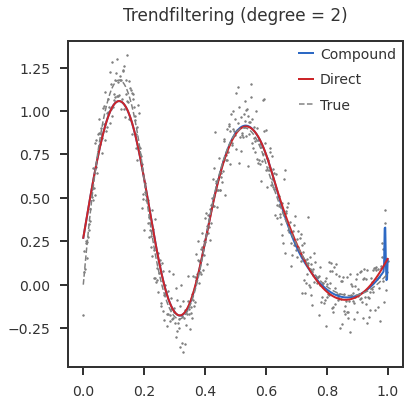

In [126]:
fig = plt.figure(figsize = (6, 6))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(data[degree].x, data[degree].y, s = 2, color = 'grey')

#ax.plot(data[degree].x, np.dot(H, gv0.coef) + gv0.intercept, lw = 2, label = 'Initial')
ax.plot(data[degree].x, np.dot(H, gv1.coef) + gv1.intercept, lw = 2, label = 'Compound')
ax.plot(data[degree].x, np.dot(H, gv2.coef) + gv2.intercept, lw = 2, label = 'Direct')
ax.plot(data[degree].x, data[degree].ytrue, label = 'True', color = 'grey', ls = 'dashed')
ax.set_title(f"Trendfiltering (degree = {degree})", pad = 20)
ax.legend()
plt.show()

In [111]:
prior.sk

array([ 0.        ,  0.50596585,  1.26793316,  2.41542989,  4.1435208 ,
        6.74596669, 10.66516135, 16.56733468, 25.45580619, 38.84154077])